In [101]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_array
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
train_images = np.load("mnist_c_identity/train_images.npy")
train_labels = np.load("mnist_c_identity/train_labels.npy")

test_images = np.load("mnist_c_identity/test_images.npy")
test_labels = np.load("mnist_c_identity/test_labels.npy")

In [111]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
def rolling_window(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

def window2(arr, shape=(3, 3)):
    r_extra = np.floor(shape[0] / 2).astype(int)
    c_extra = np.floor(shape[1] / 2).astype(int)
    out = np.empty((arr.shape[0] + 2 * r_extra, arr.shape[1] + 2 * c_extra))
    out[:] = np.nan
    out[r_extra:-r_extra, c_extra:-c_extra] = arr
    view = rolling_window(out, shape)
    return view

In [112]:
patches = window2(train_images,(5,5))

ValueError: could not broadcast input array from shape (60000,28,28,1) into shape (60000,28)

In [18]:
row = []
col = []
data = np.array([1]*9)
for i in range(0,5,2):
    for j in range(0,5,2):
        row.append(i)
        col.append(j)
row = np.array(row)
col = np.array(col)
mask = csc_array((data, (row, col)), shape=(5, 5)).toarray()

In [91]:
def LBP(patch,mask_idx,pad=0):
    rows,cols = mask_idx
    bits = np.nan_to_num(patch,nan=pad)[rows,cols]
    median_bit = np.median(bits)
    bits -= median_bit
    bits = np.clip(bits, 0, 1)
    bits = np.array([bits])
    return bits.dot(1 << np.arange(bits.shape[-1] - 1, -1, -1))[0]
    

In [104]:
def get_lbp_features(image):
    lbp_features = []
    for e in window2(image.reshape(28,28),(5,5)):
        for f in e:
            lbp_features.append(LBP(f,[row,col]))
    return np.array(lbp_features).reshape(28,28)

In [105]:
all_lbp_features_train = []

for each in tqdm(train_images):
    all_lbp_features_train.append(get_lbp_features(each))

  0%|          | 275/60000 [00:16<58:50, 16.92it/s]  


KeyboardInterrupt: 

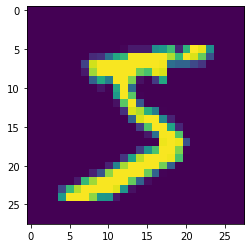

In [168]:
plt.imshow(np.array(train_images[0]).reshape((28,28)))

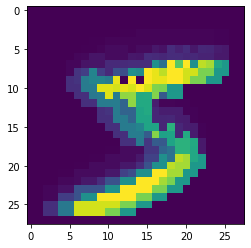

In [96]:
plt.imshow(np.array(lbp_features).reshape((28,28)))

In [56]:
LBP(patches[9,9],[row,col])

(5, 5)


216.0

In [116]:
def cycle_permutation(N,seed=101):
    np.random.seed(seed)
    a = np.arange(N)
    for i in range(N-1):
        j = np.random.randint(i+1,N)
        a[[j,i]] = a[[i,j]]
    return a

In [169]:
def ShiftsByPerm4InvFast(inCVarray,perm_y,perm_x,perm_y1,perm_x1):
    inCVarray = perm_y[inCVarray]
    inCVarray = perm_x[inCVarray]
    inCVarray = perm_y1[inCVarray]
    outCVarray = perm_x1[inCVarray]
    return outCVarray

In [118]:
cycle_permutation(10).shape[-1]

10

In [163]:
def get_permutations(y_dim, x_dim, DC, DC_ratio, N, seed, y2_dim, x2_dim, DC2, DC2_ratio):
    np.random.seed(seed)
    DcX = round(DC*DC_ratio)
    DcX2 = round(DC2*DC2_ratio)
    
    permutation_y0 = cycle_permutation(N,seed)
    inverse_permutation_y0 = np.zeros(permutation_y0.shape[-1])
    inverse_permutation_y0[permutation_y0] = np.arange(permutation_y0.shape[-1])
    no_permutation = np.arange(N).T
    
    permutation_y = np.copy(permutation_y0).T
    perm_compos_col = np.copy(permutation_y0)
    for k in range(1,y_dim+DC-1):
        perm_compos_col = np.copy(permutation_y0[perm_compos_col])
        permutation_y = np.c_[permutation_y,perm_compos_col.T]
        
    
    permutation_y_inv = np.copy(inverse_permutation_y0).T
    perm_compos_col_inv = np.copy(inverse_permutation_y0)
    for k in range(1,y_dim+DC-1):
        perm_compos_col_inv = np.copy(inverse_permutation_y0[perm_compos_col_inv.astype(np.uint8)])
        permutation_y_inv = np.c_[permutation_y_inv,perm_compos_col_inv.T]
    
    permutation_y_inv = np.fliplr(permutation_y_inv)
    perm_y_all = np.concatenate([permutation_y_inv, np.expand_dims(no_permutation,-1), permutation_y],axis=1)
    
    
    permutation_x = np.expand_dims(np.copy(perm_compos_col).T,-1)
    perm_compos_col1 = np.copy(perm_compos_col)
    for k in range(1,x_dim+DcX-1):
        perm_compos_col1 = np.copy(perm_compos_col[perm_compos_col1.astype(np.uint8)])
        permutation_x = np.c_[permutation_x,perm_compos_col[permutation_x[:,k-1].flatten().astype(np.uint8)].T]
        
    
    permutation_x_inv = np.expand_dims(np.copy(perm_compos_col_inv).T,-1)
    perm_compos_col_inv1 = np.copy(perm_compos_col_inv)
    for k in range(1,x_dim+DcX-1):
        perm_compos_col_inv1 = np.copy(perm_compos_col_inv[perm_compos_col_inv1.astype(np.uint8)])
        permutation_x_inv = np.c_[permutation_x_inv,perm_compos_col_inv[permutation_x_inv[:,k-1].flatten().astype(np.uint8)].T]
    
    permutation_x_inv = np.fliplr(permutation_x_inv)
    perm_x_all = np.concatenate([permutation_x_inv, np.expand_dims(no_permutation,-1), permutation_x],axis=1)
    
    
    permutation_y1 = np.expand_dims(np.copy(perm_compos_col1).T,-1)
    perm_compos_col2 = np.copy(perm_compos_col1)
    for k in range(1,y2_dim+DC2-1):
        perm_compos_col2 = np.copy(perm_compos_col1[perm_compos_col2.astype(np.uint8)])
        permutation_y1 = np.c_[permutation_y1,perm_compos_col1[permutation_y1[:,k-1].flatten().astype(np.uint8)].T]
        
    
    permutation_y1_inv = np.expand_dims(np.copy(perm_compos_col_inv1).T,-1)
    perm_compos_col_inv2 = np.copy(perm_compos_col_inv1)
    for k in range(1,y2_dim+DC2-1):
        perm_compos_col_inv2 = np.copy(perm_compos_col_inv1[perm_compos_col_inv2.astype(np.uint8)])
        permutation_y1_inv = np.c_[permutation_y1_inv,perm_compos_col_inv1[permutation_y1_inv[:,k-1].flatten().astype(np.uint8)].T]
    
    permutation_y1_inv = np.fliplr(permutation_y1_inv)
    perm_y1_all = np.concatenate([permutation_y1_inv, np.expand_dims(no_permutation,-1), permutation_y1],axis=1)
    
    
    
    permutation_x1 = np.expand_dims(np.copy(perm_compos_col2).T, -1)
    perm_compos_col3 = np.copy(perm_compos_col2)
    for k in range(1,x2_dim+DcX2-1):
        perm_compos_col3 = np.copy(perm_compos_col2[perm_compos_col3.astype(np.uint8)])
        permutation_x1 = np.c_[permutation_x1,perm_compos_col2[permutation_x1[:,k-1].flatten().astype(np.uint8)].T]
        
    
    permutation_x1_inv = np.expand_dims(np.copy(perm_compos_col_inv2).T, -1)
    perm_compos_col_inv3 = np.copy(perm_compos_col_inv2)
    for k in range(1,x2_dim+DcX2-1):
        perm_compos_col_inv3 = np.copy(perm_compos_col_inv2[perm_compos_col_inv3.astype(np.uint8)])
        permutation_x1_inv = np.c_[permutation_x1_inv,perm_compos_col_inv2[permutation_x1_inv[:,k-1].flatten().astype(np.uint8)].T]
    
    permutation_x1_inv = np.fliplr(permutation_x1_inv)
    perm_x1_all = np.concatenate([permutation_x1_inv, np.expand_dims(no_permutation,-1), permutation_x1],axis=1)
    
    
    
    
    
    return perm_y_all, perm_x_all, perm_y1_all, perm_x1_all
    
    

In [164]:
tyt = get_permutations(38,38,4,1,1000,101,511,1,1,1)

In [ ]:
def make_codevector_matrix(y_dim, x_dim, DC, DC_ratio, N, seed, y2_dim, x2_dim, DC2, DC2_ratio,p,cyc):
    np.random.seed(seed)
    DcX = round(DC*DC_ratio)
    DcX2 = round(DC2*DC2_ratio)
    Np = round(p)
    
    
    perm_all = get_permutations(y_dim, x_dim, DC, DC_ratio, N, seed, y2_dim, x2_dim, DC2, DC2_ratio)
    perm_y_all = perm_all[0]
    perm_x_all = perm_all[1]
    perm_y_all1 = perm_all[2]
    perm_x_all2 = perm_all[3]
    
    
    no_permutation = np.arange(N)
    base_permutation = np.random.permutation(N)
    base_vec = base_permutation[:Np]
    inCV1 = np.array()
    
    if cyc == 1:
        perm_y0 = cycle_permutation(N,seed)
    
    base_permutation = perm_y0[base_vec]
    
    for jj1 in range(DcX2):
        perm_x1 = perm_x_all[:,jj1+x2_dim+DcX2-1]
        
        for ii1 in range(DC2):
            perm_y1 = perm_y_all1[:,ii1+y2_dim+DcX2-1]
            
            for jj in range(DcX):
                perm_x = perm_x_all[:,jj+x_dim+DcX-1]
                
                for ii in range(DC):
                    
                    perm_y = perm_y_all[:,ii+y_dim+DC-1]
                    
                    inCV1(num:num+Np-1) = ShiftsByPerm4InvFast(base_vec,perm_y,perm_x,perm_y1,perm_x1);
                    num = num + Np;